# Autoencoder report plots

This notebook reproduces the figures in the Solid Earth paper which show the conditional autoencoder results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from analysis import load_model, load_testdataset, plot_result
import multiprocessing as mp

In [2]:
# Global constants
DT = 0.002
T_GAIN = 2.5
DX,DZ = 5., 5.
NX,NZ = 128, 128
NREC,NSTEPS = 32, 512
DELTARECi = 3

# define gain profile for display
t_gain = np.arange(NSTEPS, dtype=np.float32)**T_GAIN
t_gain = t_gain/np.median(t_gain)
t_gain = t_gain.reshape((1,1,1,NSTEPS))# along NSTEPS
VLIM = 0.6
CLIM = (1500,3600)
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

## Forward: velocity variation

In [3]:
# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("fault_2ms_r_validate.bin", N_EXAMPLES=3000, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.arange(100)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

Loading model from: server/models/fault_cae/model_03000000.torch
3000 examples
[   0    1    2 ... 2997 2998 2999]
torch.Size([100, 1, 128, 128])
torch.Size([100, 2, 1, 1])
torch.Size([100, 1, 32, 512])


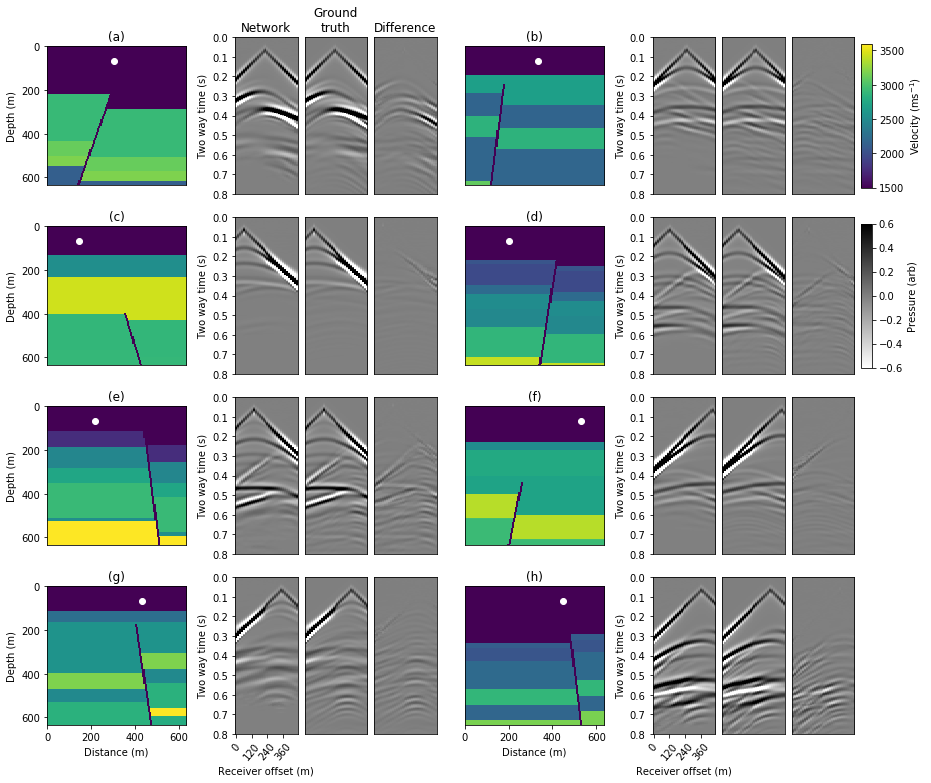

In [4]:
ibs = np.arange(0,3*8,3)+0# as velocity model goes in threes
f = plt.figure(figsize=0.8*np.array([14.5,12.5]))
for i in range(0,8):
    ib = ibs[i]
    
    # velocity
    ncol=12
    nrow=4
    ax = f.add_axes([(6*(i%2)+0)/ncol, (nrow-1-i//2)/nrow, 2/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im0 = plt.imshow(inputs_array[ib,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    plt.scatter(NX*source_array[ib,0,:,:], NX*source_array[ib,1,:,:], c="white")
    if i//2 == 3:
        plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
        plt.xlabel("Distance (m)")
    else: plt.xticks([])
    if i%2==0:
        plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
        plt.ylabel("Depth (m)")
    else: plt.yticks([])
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    plt.title("(%s)"%(letters[i]))
    
    # gather (NN)
    ax = f.add_axes([(6*(i%2)+2.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im1 = plt.imshow((t_gain*outputs_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    if i//2 == 3:
        plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
        plt.xlabel("Receiver offset (m)")
        plt.xticks(rotation=50)
    else: plt.xticks([])
    plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
    plt.ylabel("Two way time (s)")
    plt.ylim(400,0)
    if i==0:
        plt.title("Network")
    
    # gather (Ground truth)
    ax = f.add_axes([(6*(i%2)+3.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    plt.imshow((t_gain*labels_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    if i==0:
        plt.title("Ground\ntruth")
        
    # gather (diff)
    ax = f.add_axes([(6*(i%2)+4.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    plt.imshow((t_gain*(labels_array-outputs_array))[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    if i==0:
        plt.title("Difference")

    if i==0:
        ax = f.add_axes([11.7/ncol, 3.1/nrow, 0.15/ncol, 0.8/nrow])
        cb = f.colorbar(im0, cax=ax)
        cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
        
        ax = f.add_axes([11.7/ncol, 2.1/nrow, 0.15/ncol, 0.8/nrow])
        cb = f.colorbar(im1, cax=ax, aspect=0.01)
        cb.ax.set_ylabel('Pressure (arb)')

plt.savefig("../report_plots/fig10.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()

# Forward: shot variation

In [5]:
# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("fault_2ms_line_validate.bin", N_EXAMPLES=60, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.arange(60)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

Loading model from: server/models/fault_cae/model_03000000.torch
60 examples
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
torch.Size([60, 1, 128, 128])
torch.Size([60, 2, 1, 1])
torch.Size([60, 1, 32, 512])


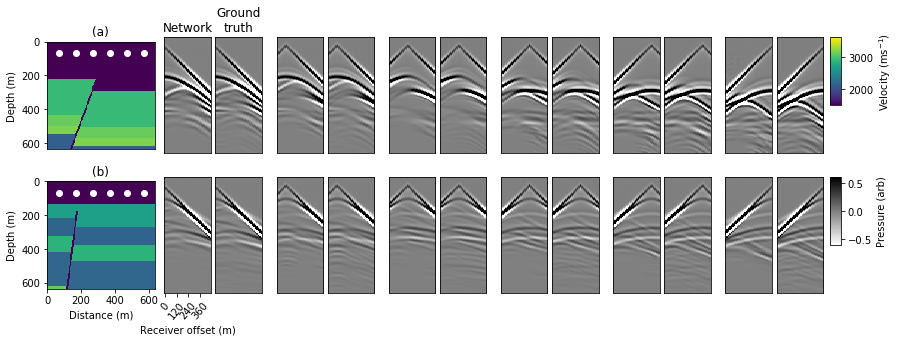

In [6]:
f = plt.figure(figsize=(15,4.7))
for i in range(2):
    
    # velocity
    plt.subplot2grid((2, 30), (i, 0), colspan=4)
    im0 = plt.imshow(inputs_array[6*i,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    plt.scatter(NX*source_array[6*i:6*i+6,0,0,0], NX*source_array[6*i:6*i+6,1,0,0], c="white")
    plt.gca().set_anchor('C')# centre plot
    if i==1:
        plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
        plt.xlabel("Distance (m)")
    else: plt.xticks([])
    plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    plt.ylabel("Depth (m)")
    plt.title("(%s)"%(letters[i]))
    
    
    for source_i in range(6):
        
        # gather
        plt.subplot2grid((2, 30), (i, 4+4*source_i), colspan=2)
        im1 = plt.imshow((t_gain*outputs_array)[6*i+source_i,0,:,:].T,
                   aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
        if i==1 and source_i==0:
            plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
            plt.xlabel("Receiver offset (m)")
            plt.xticks(rotation=50)
        else: plt.xticks([])
        plt.yticks([])
        plt.ylim(400,0)
        plt.gca().set_anchor('E')# centre plot
        if source_i==0 and i==0:
            plt.title("Network")

        # gather
        plt.subplot2grid((2, 30), (i, 4+4*source_i+2), colspan=2)
        plt.imshow((t_gain*labels_array)[6*i+source_i,0,:,:].T,
                   aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
        plt.xticks([])
        plt.yticks([])
        plt.ylim(400,0)
        plt.gca().set_anchor('W')# centre plot
        if source_i==0 and i==0:
            plt.title("Ground\ntruth")
        
    if i%2==1:
        ax = f.add_axes([0.85, 0.68, 0.01, 0.20])
        cb = f.colorbar(im0, cax=ax)
        cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
        
        ax = f.add_axes([0.85, 0.267, 0.01, 0.20])
        cb = f.colorbar(im1, cax=ax, aspect=0.01)
        cb.ax.set_ylabel('Pressure (arb)')

plt.savefig("../report_plots/fig11.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()

# Forward: quantitative loss, and other model examples

In [7]:
# get marmousi loss first

# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("marmousi_2ms.bin", rootdir="../marmousi/data/", N_EXAMPLES=3*100, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.arange(3*100)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

# l1 gain loss (by sample)
l1_gain = np.abs(t_gain*(labels_array - outputs_array))

# averaged over gather
loss2 = np.mean(l1_gain, axis=(1,2,3))

marmousi_result = [("","baseline (Marmousi)"), 0, np.concatenate([loss2,loss2,loss2]), 0, 0]

Loading model from: server/models/fault_cae/model_03000000.torch
300 examples
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 2

In [8]:
# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("fault_2ms_r_validate.bin", N_EXAMPLES=3000, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.arange(1000)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

Loading model from: server/models/fault_cae/model_03000000.torch
3000 examples
[   0    1    2 ... 2997 2998 2999]
torch.Size([1000, 1, 128, 128])
torch.Size([1000, 2, 1, 1])
torch.Size([1000, 1, 32, 512])


In [9]:
names = [("fault_cae", "baseline"), 
         ("fault_cae_l2", "L2 loss"), 
         ("fault_cae_gain0/model_01000000.torch", "$g$=0"),
         ("fault_cae_gain5", "$g$=5"),
         ("fault_cae_shallow", "shallow"),
         ("fault_cae_narrow", "thin")]

inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
source_array = inputs[1].detach().cpu().numpy().copy()
labels_array = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

def compute_loss(name):

    # Load model
    model, c_dict = load_model(name[0], verbose=False)

    # Inference
    with torch.no_grad():# faster inference without tracking
        model.eval()
        outputs = model(*inputs)
        outputs_array = outputs[0].detach().cpu().numpy().copy()

    # Get losses
    
    # l1 gain loss (by sample)
    l1_gain = np.abs(t_gain*(labels_array - outputs_array))
    labels_gain = (t_gain*labels_array)
    
    # averaged over gather
    loss2 = np.mean(l1_gain, axis=(1,2,3))

    # averaged over filtered gather
    loss3 = [np.mean(l1_gain[i][np.abs(labels_gain[i])>0.02]) for i in range(labels_array.shape[0])]

    return name, l1_gain, loss2, loss3, outputs_array

p = mp.Pool(6)
results = p.map(compute_loss, names)
results = sorted(results, key=lambda r: np.mean(r[2]))# sort by gain loss
p.close()

results.append(marmousi_result)# add marmousi loss

Loading model from: server/models/fault_cae/model_03000000.torch
Loading model from: server/models/fault_cae_gain0/model_01000000.torch
Loading model from: server/models/fault_cae_gain5/model_03000000.torch
Loading model from: server/models/fault_cae_l2/model_03000000.torch
Loading model from: server/models/fault_cae_shallow/model_03000000.torch
Loading model from: server/models/fault_cae_narrow/model_03000000.torch


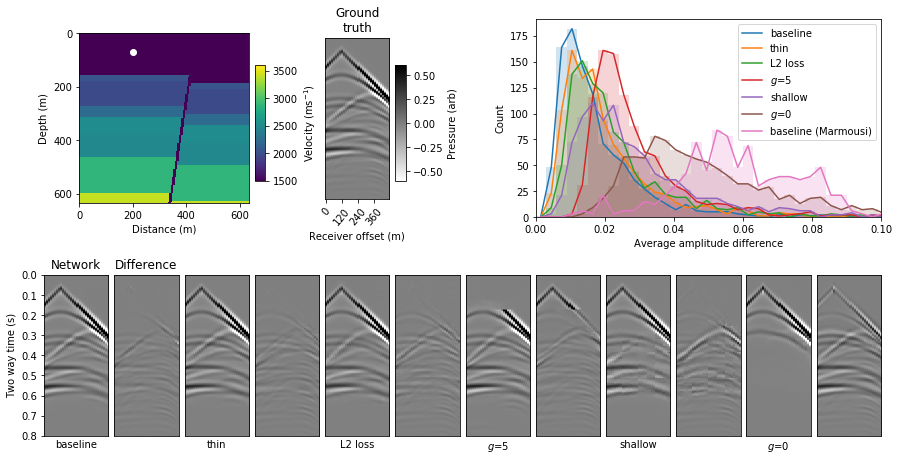

In [10]:
%matplotlib inline

ib = 9

f = plt.figure(figsize=(15,8))
    
# velocity
plt.subplot2grid((2, 24), (0, 1), colspan=5)
im0 = plt.imshow(inputs_array[ib,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
plt.scatter(NX*source_array[ib,0,0,0], NX*source_array[ib,1,0,0], c="white")
plt.gca().set_anchor('C')# centre plot
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")

# gather (Ground truth)
plt.subplot2grid((2, 24), (0, 8), colspan=2)
im1 = plt.imshow((t_gain*labels_array)[ib,0,:,:].T,
           aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
plt.xticks([])
plt.yticks([])
plt.ylim(400,0)
plt.gca().set_anchor('W')# centre plot
plt.title("Ground\ntruth")
plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
plt.xlabel("Receiver offset (m)")
plt.xticks(rotation=50)


ax = f.add_axes([0.32, 0.6, 0.01, 0.20])
cb = f.colorbar(im0, cax=ax)
cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')

ax = f.add_axes([0.45, 0.6, 0.01, 0.20])
cb = f.colorbar(im1, cax=ax, aspect=0.01)
cb.ax.set_ylabel('Pressure (arb)')


for i_model in range(6):
    
    outputs_array = results[i_model][-1]
    name = results[i_model][0][1]
    
    # gather (NN)
    plt.subplot2grid((2, 24), (1, 4*i_model), colspan=2)
    plt.imshow((t_gain*outputs_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.gca().set_anchor('E')# centre plot
    if i_model==0:
        plt.title("Network")
        plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
        plt.ylabel("Two way time (s)")
        plt.ylim(400,0)
    else:
        plt.yticks([])
        plt.ylim(400,0)

    plt.xlabel(name)
        
    # gather (difference)
    plt.subplot2grid((2, 24), (1, 4*i_model+2), colspan=2)
    plt.imshow((t_gain*(labels_array-outputs_array))[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('W')# centre plot
    if i_model==0:
        plt.title("Difference")

# plot losses

plt.subplot2grid((2, 24), (0, 14), colspan=10)
for i in range(len(results)):
    x = np.arange(0,0.2,0.003)
    plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(results[i][2], bins=x)[0], label=results[i][0][1])
    plt.hist(results[i][2], bins=x, histtype='stepfilled', alpha=0.2, color=colors[i])
plt.legend()
    
plt.xlabel("Average amplitude difference")
plt.ylabel("Count")
plt.xlim(0,0.1)

plt.subplots_adjust(wspace=0.2)

plt.savefig("../report_plots/figA2.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()

# Generalisation tests (marmousi)

In [11]:
# Load all training velocity models
vels = np.stack([np.load("../generate_data/velocity/fault/all/velocity_%.8i.npy"%(i)) for i in range(100000)],axis=0)
print(vels.shape)

(100000, 128, 128)


In [12]:
# Load model and dataset (marmousi)
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("marmousi_2ms.bin", rootdir="../marmousi/data/", N_EXAMPLES=3*100, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.array([4,1,91,86,64])*3

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()

    
    
    
# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
d = load_testdataset("fault_2ms_r_validate.bin", N_EXAMPLES=3000, c_dict=c_dict, verbose=False)

# Get batches of test data
irange = np.array([3,5,7])*3

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = np.concatenate([inputs_array,inputs[0].detach().cpu().numpy().copy()])# detach returns a new tensor, detached from the current graph
    source_array = np.concatenate([source_array,inputs[1].detach().cpu().numpy().copy()])
    outputs_array = np.concatenate([outputs_array,outputs[0].detach().cpu().numpy().copy()])
    labels_array = np.concatenate([labels_array,labels[0].detach().cpu().numpy().copy()])

    
# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

Loading model from: server/models/fault_cae/model_03000000.torch
300 examples
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 2

In [13]:
# find nearest neighbours
split = np.array_split(vels, 8)
neighbours = []
for ib in np.arange(inputs_array.shape[0]):
    vel = inputs_array[ib:ib+1,0]
    def loss_func(i): return np.mean(np.abs(split[i]-vel), axis=(1,2))
    with mp.Pool(processes=8) as pool: loss = np.concatenate(pool.map(loss_func, np.arange(8)))
    print(len(loss))
    a = np.argsort(loss)
    neighbours.append(a[0])
print(neighbours)

100000
100000
100000
100000
100000
100000
100000
100000
[56576, 85654, 39137, 51102, 50620, 3450, 173, 60603]


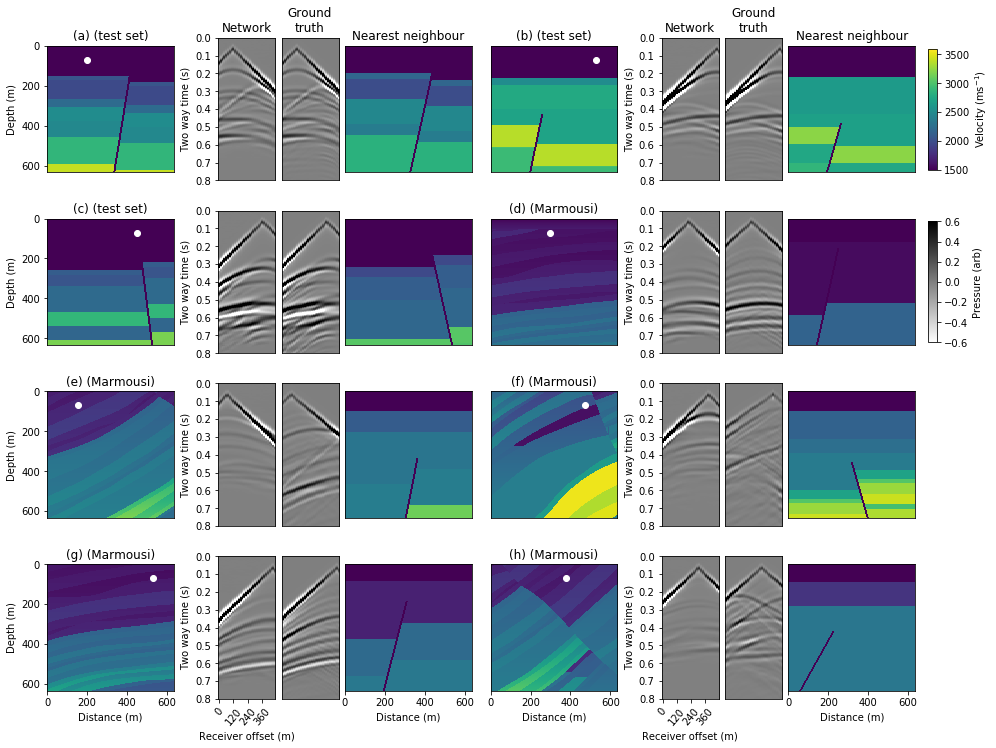

In [14]:
ibs = [5,6,7,0,1,2,3,4]
titles = ["(a) (test set)", "(b) (test set)", "(c) (test set)", "(d) (Marmousi)", "(e) (Marmousi)", "(f) (Marmousi)", "(g) (Marmousi)", "(h) (Marmousi)"]

f = plt.figure(figsize=0.8*np.array([16.5,12]))
for i in range(0,8):
    ib = ibs[i]
    
    # velocity
    ncol=15
    nrow=4
    ax = f.add_axes([(7*(i%2)+0)/ncol, (nrow-1-i//2)/nrow, 2/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im0 = plt.imshow(inputs_array[ib,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    plt.scatter(NX*source_array[ib,0,:,:], NX*source_array[ib,1,:,:], c="white")
    if i//2 == 3:
        plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
        plt.xlabel("Distance (m)")
    else: plt.xticks([])
    if i%2==0:
        plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
        plt.ylabel("Depth (m)")
    else: plt.yticks([])
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    plt.title("%s"%(titles[i]))
    
    # gather (NN)
    ax = f.add_axes([(7*(i%2)+2.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im1 = plt.imshow((t_gain*outputs_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    if i//2 == 3:
        plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
        plt.xlabel("Receiver offset (m)")
        plt.xticks(rotation=50)
    else: plt.xticks([])
    plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
    plt.ylabel("Two way time (s)")
    plt.ylim(400,0)
    if i in [0,1]:
        plt.title("Network")
    
    # gather (Ground truth)
    ax = f.add_axes([(7*(i%2)+3.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    plt.imshow((t_gain*labels_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    if i in [0,1]:
        plt.title("Ground\ntruth")

        
    # velocity (NN)
    
    ax = f.add_axes([(7*(i%2)+4.7)/ncol, (nrow-1-i//2)/nrow, 2/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im0 = plt.imshow(vels[neighbours[ib]].T, vmin=CLIM[0], vmax=CLIM[1])
    if i//2 == 3:
        plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
        plt.xlabel("Distance (m)")
    else: plt.xticks([])
    plt.yticks([])
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    if i in [0,1]: plt.title("Nearest neighbour")
    
    
    if i==0:
        ax = f.add_axes([13.9/ncol, 3.15/nrow, 0.15/ncol, 0.7/nrow])
        cb = f.colorbar(im0, cax=ax)
        cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
        
        ax = f.add_axes([13.9/ncol, 2.15/nrow, 0.15/ncol, 0.7/nrow])
        cb = f.colorbar(im1, cax=ax, aspect=0.01)
        cb.ax.set_ylabel('Pressure (arb)')

plt.savefig("../report_plots/fig12.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()